# Experiment and path specification

In [8]:
# Specify the experiment for analysis
experiment='cxilu9218'
runNumber = 21

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [9]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

igabalsk



# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [10]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

# Load timebinned CSPAD

### This can either take a timebinned single run (Section 1) or a set of separate runs at different time delays and stitch them into a single ROI analysis (Section 2)

In [11]:
# SECTION 1
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)
# END SECTION 1

# SECTION 2
# timebins_dict = {}
# CSPAD_dict = {}
# run_dict = {29:0, 31:1, 33:2, 32:3, 30:4, 28:5}
# for run_number in [28, 29, 30, 31, 32, 33]:
#     timebins_dict[run_number] = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % run_number )
#     CSPAD_dict[run_number] = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % run_number)

# CSPAD_summed = np.zeros((8,512,1024,6))
# runs = []
# for key in CSPAD_dict.keys():
#     runs.append(key)
#     CSPAD_run = np.nanmean(CSPAD_dict[key], axis=-1)
#     index = run_dict[key]
#     print key, index, np.mean(CSPAD_run), np.nansum(CSPAD_dict[key])
#     CSPAD_summed[:,:,:,index] = CSPAD_run
# print runs
# END SECTION 2

# Plot CSPAD

In [112]:
# print '{0:<5} {1:>5} {2:>8} {3:>8}'.format('Index','Count','Mean', 'Timebin')
# for i in range(CSPAD.shape[-1]):
#     if not np.isnan(counts[i][0]):
#         vals = (i, int(counts[i][0]), round(np.mean(CSPAD[:,:,:,i]),3), round(timebins[i],3))
#         print '{0:<5} {1:>5} {2:>8} {3:>8} '.format(*vals)
        
        
# # print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format('Index','Count','Sum','Median','Variance')
# # for i in range(CSPAD.shape[-1]):
# #     if counts[i][0]>0:
# #         vals = (i, counts[i][0], round(np.sum(CSPAD[:,:,:,i])),round(np.median(CSPAD[:,:,:,i]),4), round(np.var(CSPAD[:,:,:,i]),4))
# #         print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format(*vals)

### This has a modified plotCSPAD() function that can take in a list of tile indices for each ROI and plot the ROIs as bright spots

In [113]:
CSPADbinned = np.copy(CSPAD)
CSPADbinned[CSPADbinned>750]=0


from scipy.ndimage.filters import gaussian_filter
sigma = 10

CSPADblurred = np.zeros(CSPAD.shape)
for i in range(CSPAD.shape[-1]):
    if not np.isnan(counts[i][0]):
        for j, tile in enumerate(CSPADbinned[:,:,:,i]):
            CSPADblurred[j,:,:,i] = gaussian_filter(tile, sigma=sigma)

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [114]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8, ROIs=None ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        if ROIs:
            for mask in ROIs:
                print cspadTile.shape, mask[iTile].shape
                cspadTile[mask[iTile]] = 1000
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
        
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)

# off = np.nanmean(CSPADblurred[:,:,:,:], axis=-1)
# scaling = 1
# for frame in CSPADblurred.transpose(3,0,1,2):
#     newscaling = np.min(frame/off)
#     if newscaling<scaling and newscaling>0:
#         scaling = newscaling
# print 'Scaling: ',scaling


(8, 512, 1024)


1.1


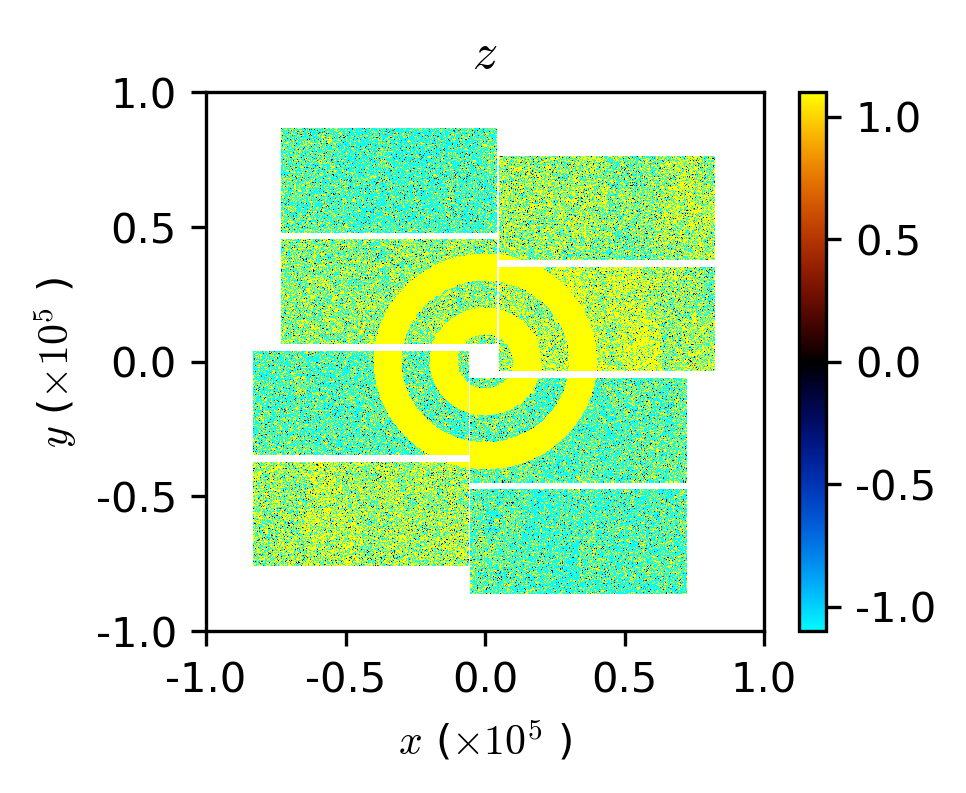

In [115]:
CSPAD_summed = np.nanmean(CSPADbinned, axis=-1)
CSPAD2plot = CSPAD[:,:,:,25]-scaling*CSPAD[:,:,:,1]
plotCSPAD( CSPAD2plot, x , y , zLims=[-1,1],
          cspadMask=cspadMask, divergent=True, NTILE=8, ROIs=[mask0, mask1] )

In [116]:
# print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format('Index','Count','Sum','Median','Variance')
# for i in range(CSPAD.shape[-1]):
#     if counts[i][0]>0:
#         vals = (i, counts[i][0], round(np.sum(CSPAD[:,:,:,i])),round(np.median(CSPAD[:,:,:,i]),4), round(np.var(CSPAD[:,:,:,i]),4))
#         print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format(*vals)

In [117]:
print np.nanmean(CSPAD), np.nanmedian(CSPAD)

-0.10970083873690477 -0.1746135640080429


# ROI analysis

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in divide


[ -1.12975534   2.10060533          nan   0.82639264   5.69161068
   1.51263161 -18.54135212          nan  -0.51465711  -4.68675583
  74.37000417  -5.08075311  28.52947387  -0.93689322  15.60379534
   6.87124857  10.29163064          nan  11.08556871 -13.20446738
 -23.38681289          nan  -1.75100929   0.30951249 -72.34980424
   1.23046177  -1.88456312   4.28787155   0.66294082          nan
   0.53172623   2.22888786          nan  -3.44832805          nan
   3.66196809  -3.72712878          nan          nan          nan
   2.81978189          nan   9.34428706  -0.42016333   4.36984552
          nan -13.2386524    3.07238293]
(38,) (36,)
Ignoring undefined input variable ...
[]


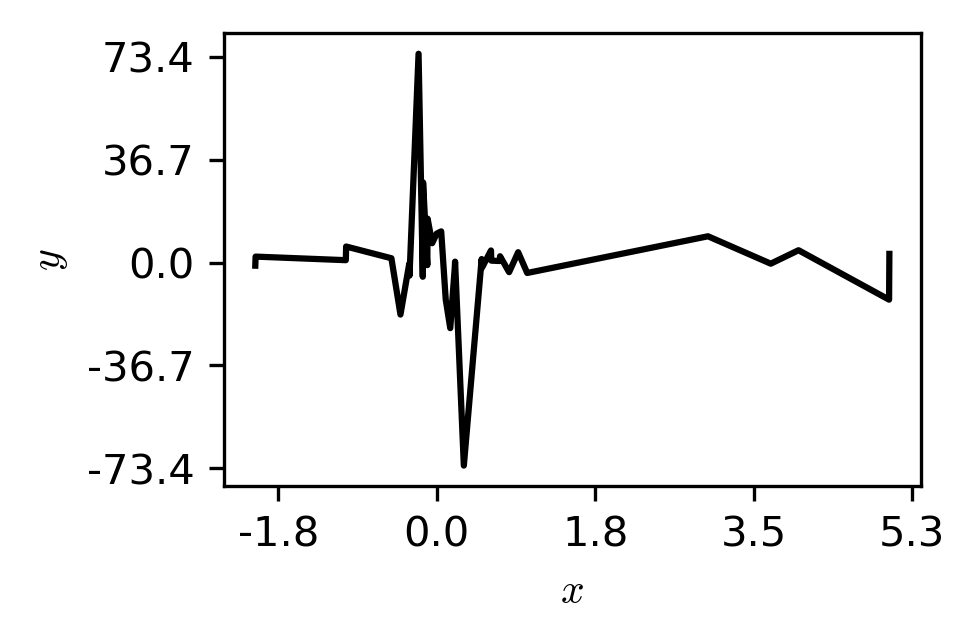

In [120]:
def roiSummed( x0, y0, dx, dy, x, y, image ):
    idx = ( x0 < x ) & ( (x0+dx) > x ) & ( y0 < y ) & ( (y0+dy) > y )
    return np.sum( image[idx , :] , 0 )

def roiSummedRadial(r0, dr, x, y, image):
    idx = (r0<np.sqrt(x**2+y**2)) & ((r0+dr)>np.sqrt(x**2+y**2))
    return np.sum(image[idx, :],0)

def roiMaskRadial(r0, dr, x, y):
    return (r0<np.sqrt(x**2+y**2)) & ((r0+dr)>np.sqrt(x**2+y**2))

def roiSummedIdx(tile, image):
    return np.sum(image[tile,206:306,462:572])

x0, y0 = -2e4, -2.5e4
x1, y1 = 5e4, -2e4
dx, dy = 1.5e4, 1.5e4

r0, r1, dr = 1e4, 3e4, 1e4
mask0 = roiMaskRadial(r0, dr, x, y)
mask1 = roiMaskRadial(r1, dr, x, y)


# roi1 = roiSummed( x0, y0, dx, dy, x, y, CSPADbinned )
# errroi1 = roiSummed( x0, y0, dx, dy, x, y, variance )
# roi2 = roiSummed( x1, y1, dx, dy, x, y, CSPADbinned )
# errroi2 = roiSummed( x1, y1, dx, dy, x, y, variance )
# roi1 = roiSummed( x0, y0, dx, dy, x, y, CSPAD_summed )
# errroi1 = roiSummed( x0, y0, dx, dy, x, y, variance )
# roi2 = roiSummed( x1, y1, dx, dy, x, y, CSPAD_summed )
# errroi2 = roiSummed( x1, y1, dx, dy, x, y, variance )

# errorratio = 1/roi2*np.sqrt(errroi1)+roi1/roi2**2*np.sqrt(errroi2)
roi1 = roiSummedRadial(r0, dr, x, y, CSPADblurred)
roi2 = roiSummedRadial(r1, dr, x, y, CSPADblurred)

ratio = roi1/roi2
plotme = ratio[~np.isnan(ratio)]#-ratio[~np.isnan(ratio)].min()
print ratio
# linePlot( timebins[~np.isnan(ratio)], plotme , newFigure = True)
print timebins[~np.isnan(roi2)].shape, plotme.shape
linePlot( timebins[~np.isnan(ratio)], plotme , newFigure = True)

# plt.errorbar( timebins[~np.isnan(ratio)], plotme, yerr = errorratio[~np.isnan(ratio)] )